Installing Dependencies

In [1]:
!pip install -U numba


In [2]:
!pip install -U shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.8 MB/s eta 0:00:00


# Importing Dependencies


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve,average_precision_score
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import shap

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading Data

In [5]:
adasyn_w_triggers_train = pd.read_csv("/content/drive/MyDrive/Data/adasyn_w_triggers_train.csv")
adasyn_w_triggers_test = pd.read_csv("/content/drive/MyDrive/Data/adasyn_w_triggers_test.csv")

In [9]:
adasyn_w_triggers_train.columns
print(adasyn_w_triggers_train.shape[1])
print(adasyn_w_triggers_test.shape[1])


40
40


# GLM

In [15]:
def log_reg(train_data, test_data):

  # Splitting data
  X_train = train_data.drop("fraud", axis= 1)
  y_train = train_data["fraud"]
  X_test = test_data.drop("fraud", axis= 1)
  y_test = test_data["fraud"]


  # fit the GLM model using LogisticRegression from SKlearn
  glm = LogisticRegression(solver= 'liblinear')
  glm.fit(X_train, y_train)


  # Testing Set
  test_prob = glm.predict_proba(X_test)[:, 1]


  # Get the ROC curve and calculate the ROC AUC
  roc_auc = roc_auc_score(y_test, test_prob)


  # Get the PR curve
  precision, recall, thresholds = precision_recall_curve(y_test, test_prob)


  # Get the PR AUC
  pr_auc = average_precision_score(y_test, test_prob)


  # Set threshold bases on the optimal ROC curve threshold
  fpr, tpr, thresholds = roc_curve(y_test, test_prob)
  threshold = thresholds[np.argmax(tpr - fpr)]


  # Create Binary predictions
  model_glm_test_pred = np.where(test_prob > threshold, 1, 0)


  # Confusion Matrix
  c_m = confusion_matrix(y_test, model_glm_test_pred)


  # Printing all the outputs
  print(f" Area Under the Curve and Receiver Operating Characterstics Curve (AUC ROC) : {roc_auc}")
  print(f" Area Under the Precision Recall Curve (PR AUC) : {pr_auc}")
  print(f" Confusion Matrix : \n{c_m}")


  fig = px.area(x= fpr, y=tpr, title= f'ROC Curve (AUC={auc(fpr, tpr):.4f})', labels= dict(x= 'Specificity', y= 'Sensitivity'), width= 700, height= 500)
  fig.add_shape( type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1 )

  fig.update_yaxes(scaleanchor="x", scaleratio=1)
  fig.update_xaxes(constrain='domain')
  fig.show()

  return  glm

In [16]:
logmodel_awt=log_reg(adasyn_w_triggers_train, adasyn_w_triggers_test)

 Area Under the Curve and Receiver Operating Characterstics Curve (AUC ROC) : 0.7829250084066475
 Area Under the Precision Recall Curve (PR AUC) : 0.7870437327905841
 Confusion Matrix : 
[[24492  7312]
 [10577 21260]]


## SHAP

In [17]:
X_test = adasyn_w_triggers_test.drop("fraud", axis= 1)

explainer = shap.Explainer(logmodel_awt, masker=shap.maskers.Impute(data=X_test),
                           feature_names=X_test.columns, algorithm="linear")

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
shap_values_glm = explainer.shap_values(X_test)

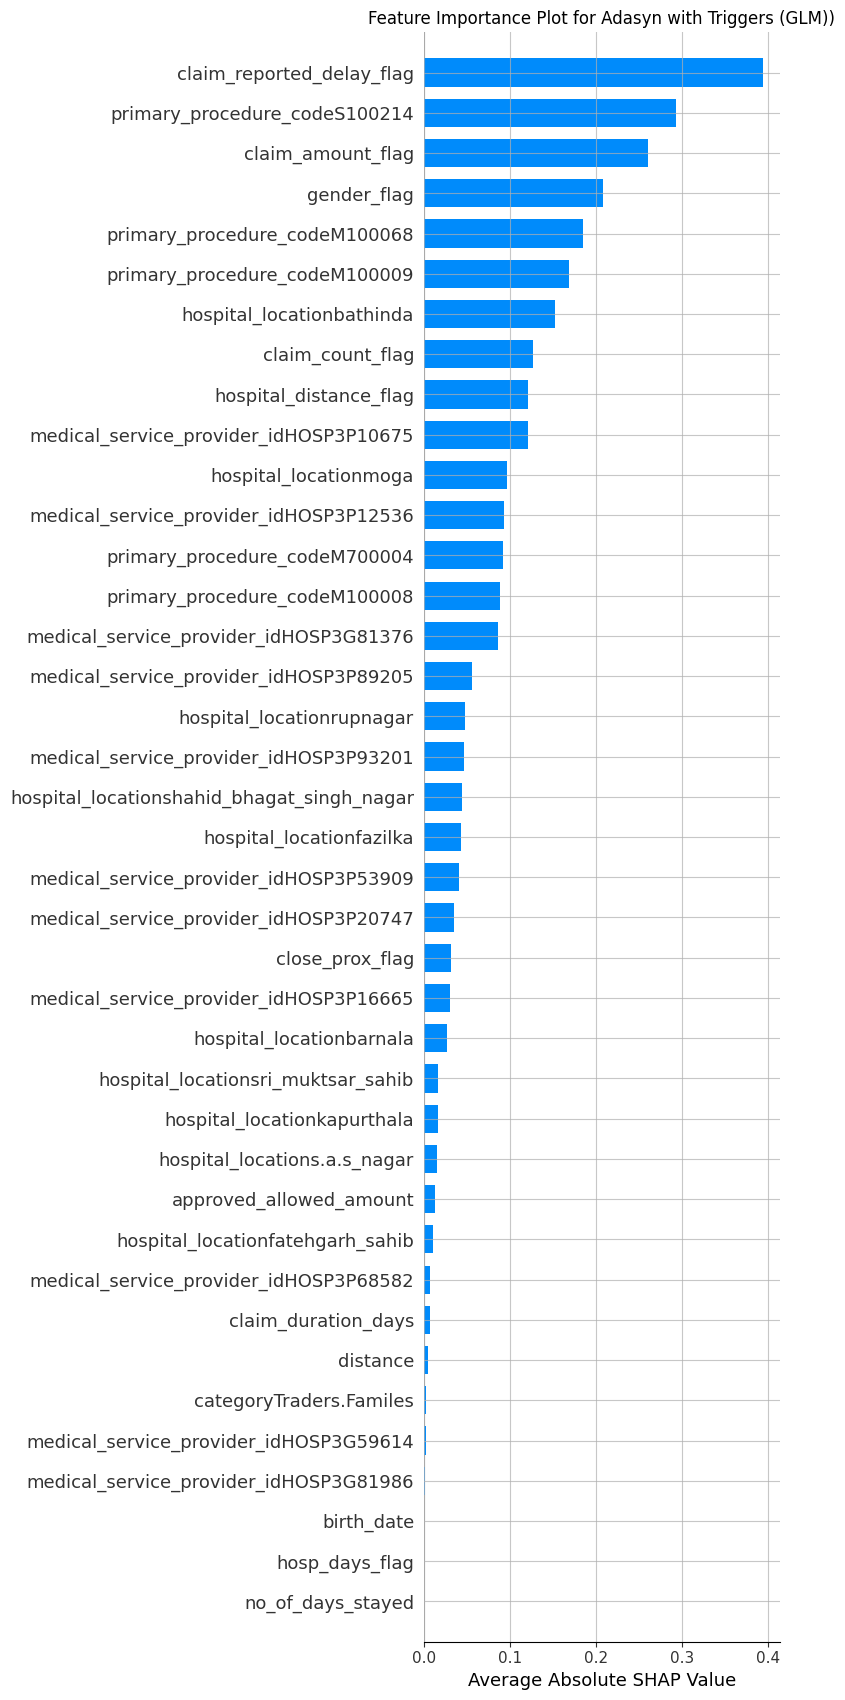

In [20]:
plt.figure(figsize=(20, 20))
plt.grid(True, axis='x', linestyle='-', alpha=0.7)
plt.grid(True, axis='y', linestyle='-', alpha=0.7)
# Plot feature importance
plt.title("Feature Importance Plot for Adasyn with Triggers (GLM))")
shap.summary_plot(shap_values_glm, X_test, plot_type='bar' ,show=False,max_display=39)
plt.xlabel('Average Absolute SHAP Value')
plt.show()

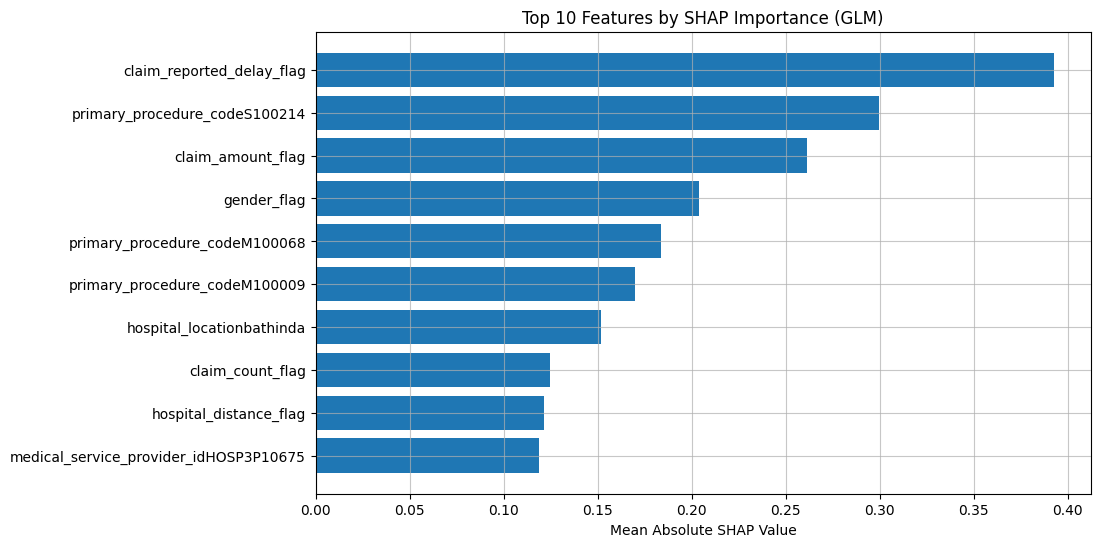

In [ ]:
mean_shap_values = np.abs(shap_values_glm).mean(0)
feature_names = X_test.columns

top_10_indices = np.argsort(mean_shap_values)[-10:]
top_10_feature_names = feature_names[top_10_indices]
top_10_mean_shap_values = mean_shap_values[top_10_indices]

# Create a bar plot to display mean SHAP values for the top 10 features
plt.figure(figsize=(10, 6))
plt.grid(True, axis='x', linestyle='-', alpha=0.7)
plt.grid(True, axis='y', linestyle='-', alpha=0.7)
plt.barh(range(len(top_10_feature_names)), top_10_mean_shap_values, tick_label=top_10_feature_names)
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Top 10 Features by SHAP Importance (GLM)')

# Display the plot
plt.show()

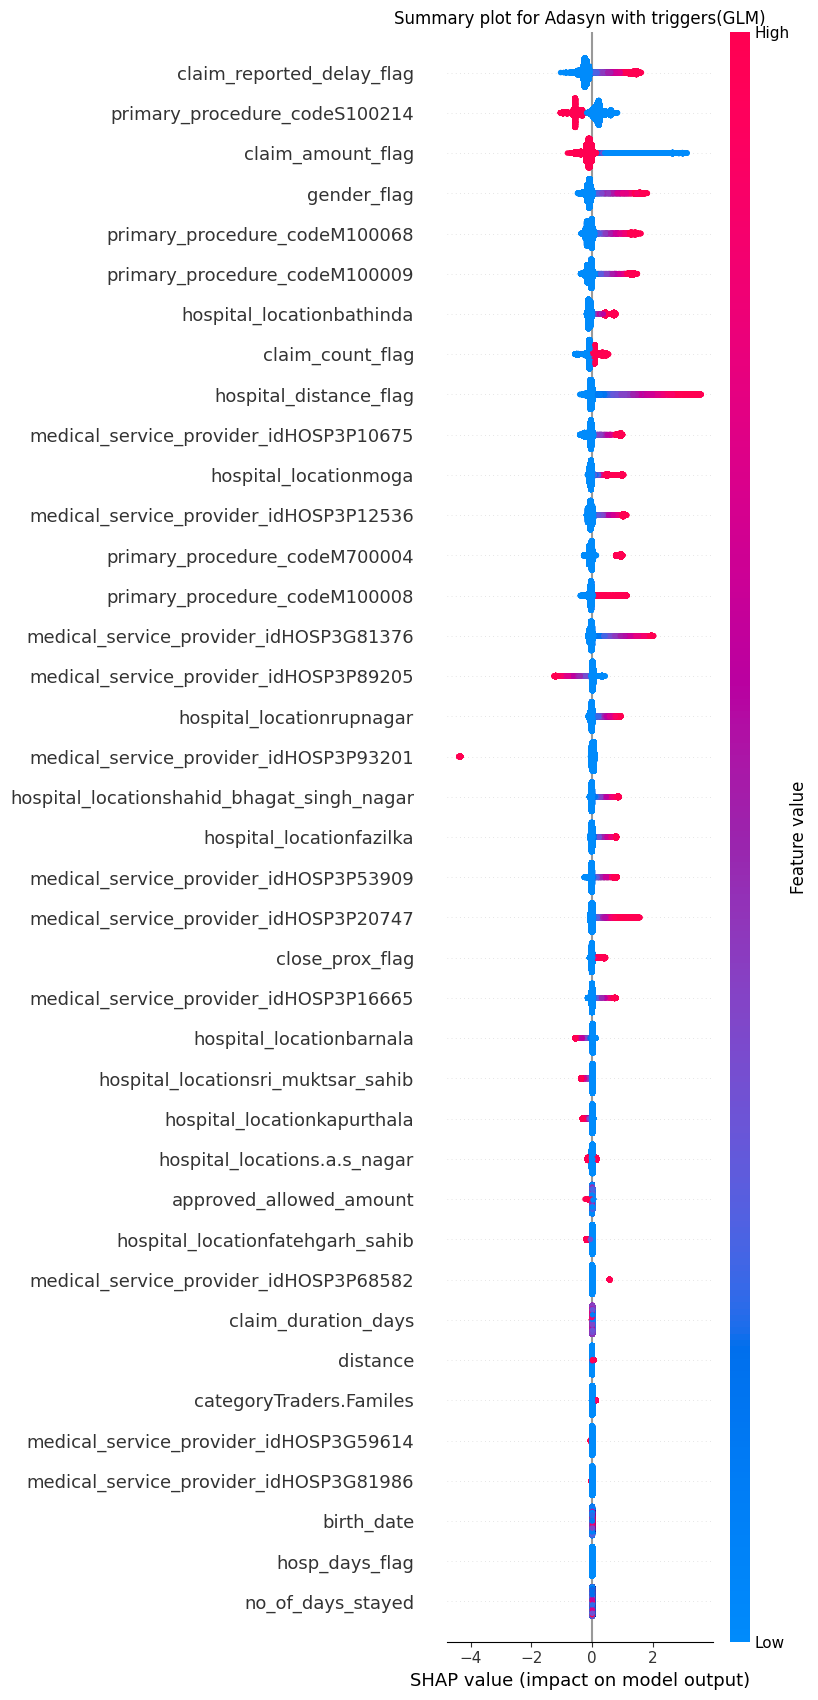

In [21]:
plt.title("Summary plot for Adasyn with triggers(GLM)")
shap.summary_plot(shap_values_glm, X_test, feature_names=X_test.columns,max_display=39)

Text(0.5, 1.0, 'Interaction plot for claim reported delay flag(GLM)')

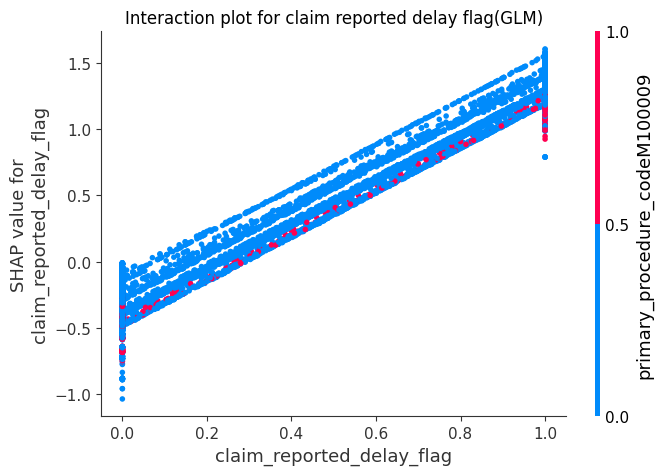

In [ ]:
shap.dependence_plot('claim_reported_delay_flag', shap_values_glm, X_test, show=False)
plt.title("Interaction plot for claim reported delay flag(GLM)" )

# XGBoost

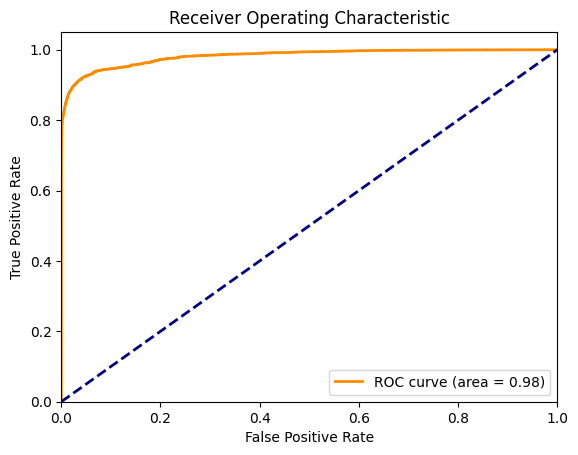

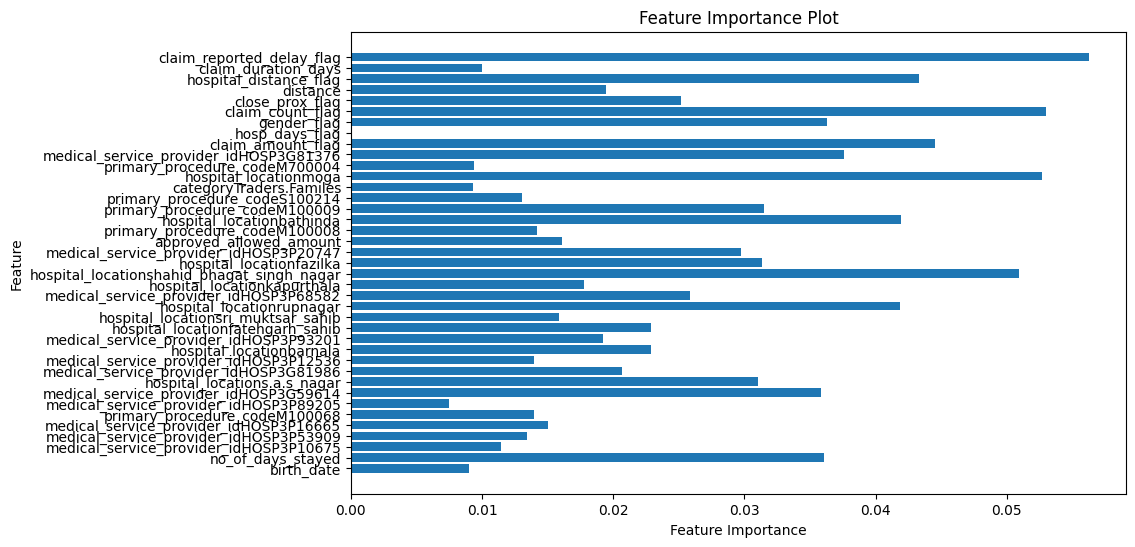

In [10]:
# Load your datasets (replace with your actual data loading code)
X_train = adasyn_w_triggers_train.drop(columns=["fraud"])
y_train = adasyn_w_triggers_train["fraud"]

X_test = adasyn_w_triggers_test.drop(columns=["fraud"])
y_test = adasyn_w_triggers_test["fraud"]

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.rcParams['font.family'] = 'Sans-Serif'
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Get feature names
feature_names = X_train.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

## SHAP

In [12]:
X_test.shape[1]

39

In [22]:
explainer = shap.Explainer(xgb_model)
shap_values_xgb = explainer.shap_values(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[03:55:21] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



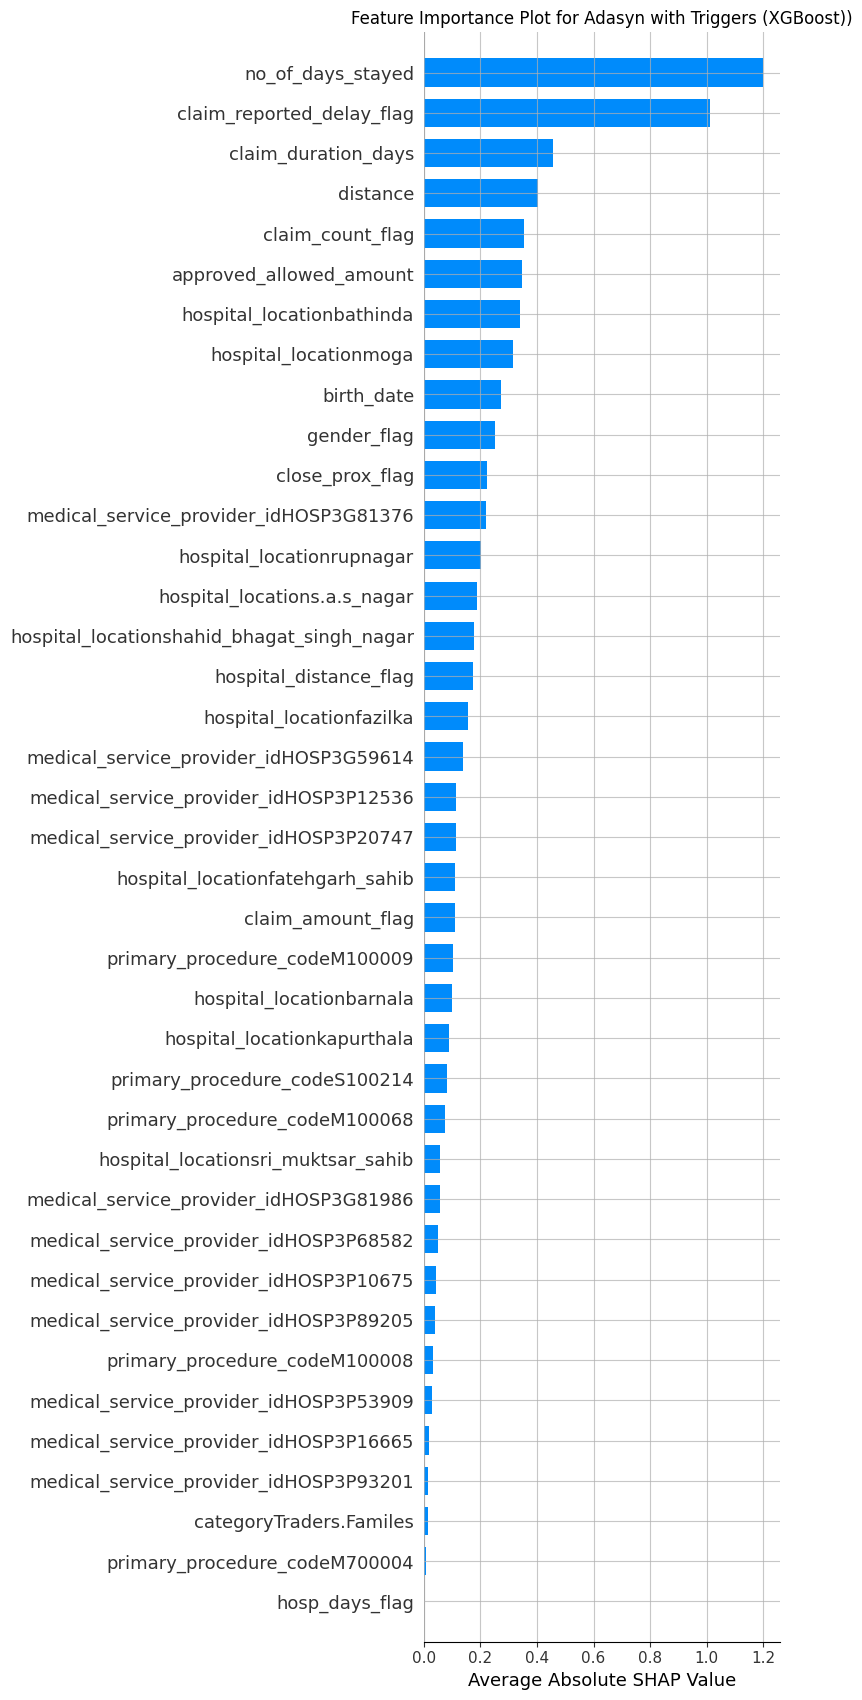

In [23]:
plt.figure(figsize=(20, 20))
plt.grid(True, axis='x', linestyle='-', alpha=0.7)
plt.grid(True, axis='y', linestyle='-', alpha=0.7)
# Plot feature importance
plt.title("Feature Importance Plot for Adasyn with Triggers (XGBoost))")
shap.summary_plot(shap_values_xgb, X_test, plot_type='bar' ,show=False,max_display=39)
plt.xlabel('Average Absolute SHAP Value')
plt.show()

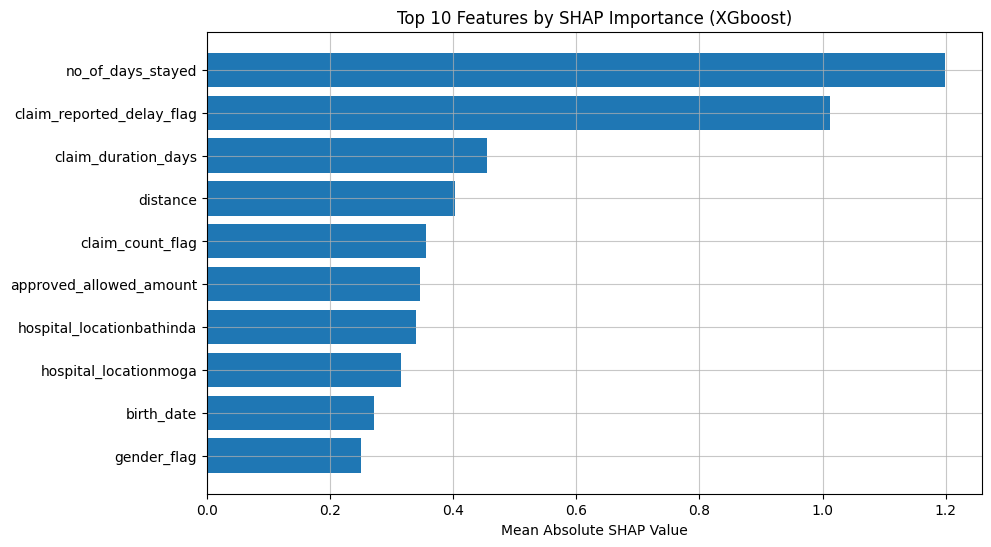

In [ ]:
mean_shap_values = np.abs(shap_values_xgb).mean(0)
feature_names = X_test.columns

top_10_indices = np.argsort(mean_shap_values)[-10:]
top_10_feature_names = feature_names[top_10_indices]
top_10_mean_shap_values = mean_shap_values[top_10_indices]

# Create a bar plot to display mean SHAP values for the top 10 features
plt.figure(figsize=(10, 6))
plt.grid(True, axis='x', linestyle='-', alpha=0.7)
plt.grid(True, axis='y', linestyle='-', alpha=0.7)
plt.barh(range(len(top_10_feature_names)), top_10_mean_shap_values, tick_label=top_10_feature_names)
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Top 10 Features by SHAP Importance (XGboost)')

# Display the plot
plt.show()

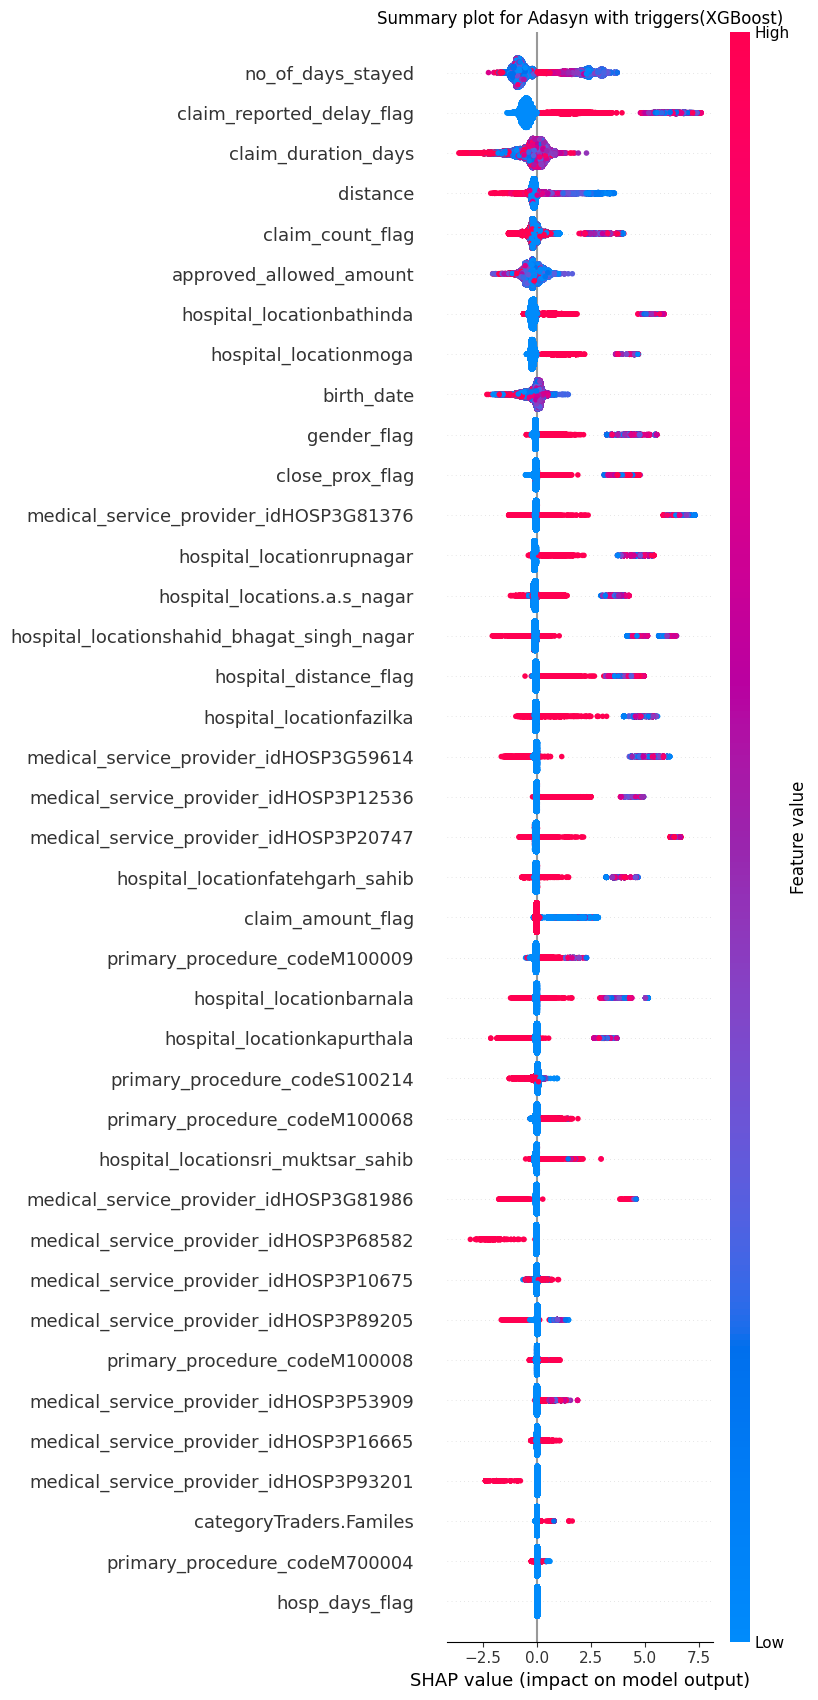

In [24]:
plt.title("Summary plot for Adasyn with triggers(XGBoost)")
shap.summary_plot(shap_values_xgb, X_test, feature_names=X_test.columns ,max_display=39)

Text(0.5, 1.0, 'Interaction plot for no_of_days_stayed(XGBoost)')

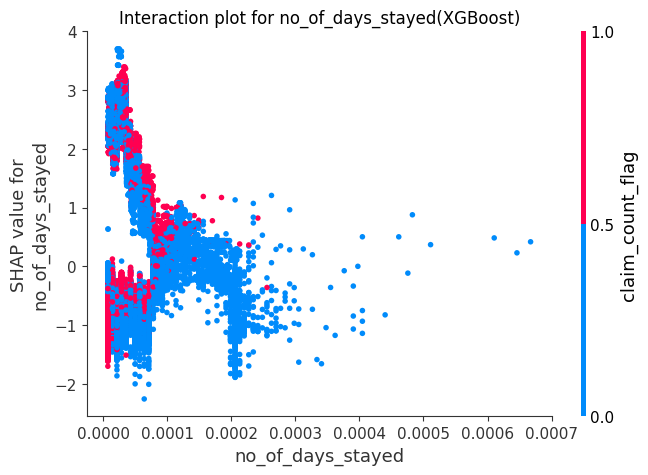

In [ ]:
shap.dependence_plot('no_of_days_stayed', shap_values_xgb, X_test, show=False)
plt.title("Interaction plot for no_of_days_stayed(XGBoost)" )

# Random Forest

Confusion Matrix:
[[29092  2712]
 [ 2759 29078]]
ROC AUC: 0.964006897604804
PR AUC: 0.9599978717126976


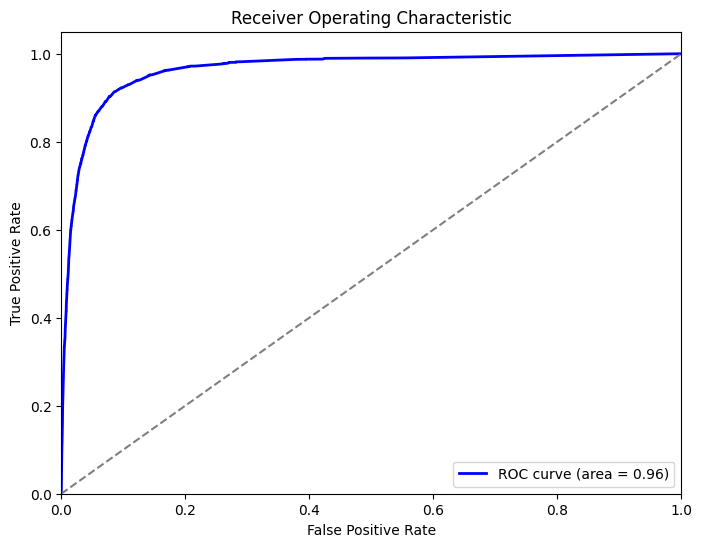

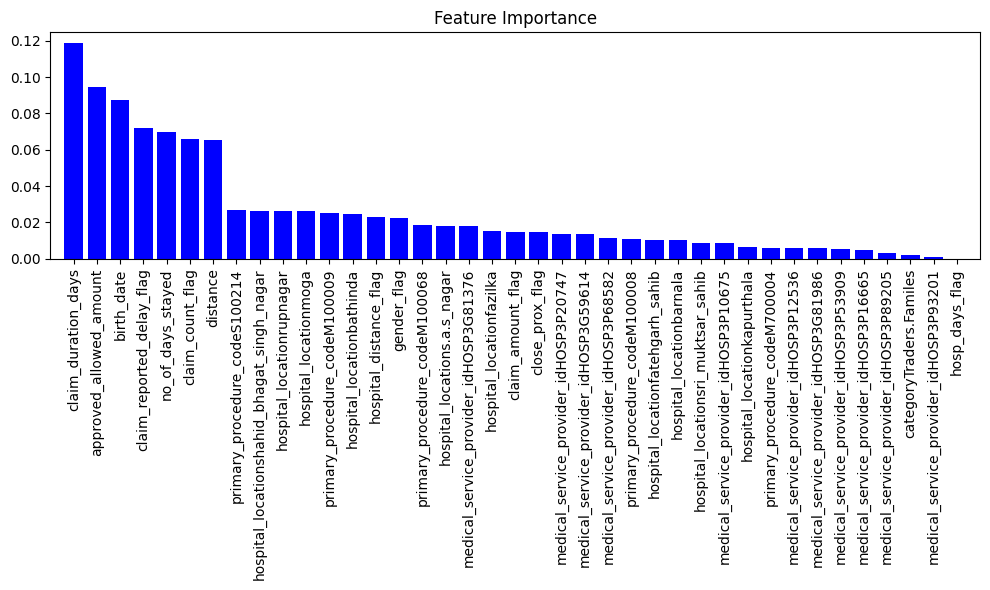

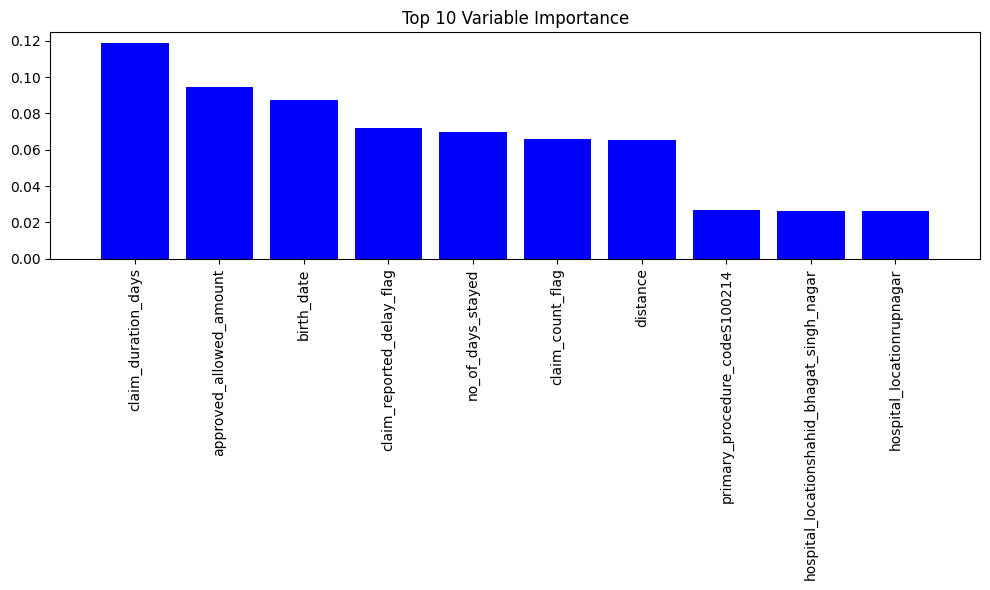

In [25]:
# Split the data into features and labels
X_train = adasyn_w_triggers_train.drop("fraud", axis=1)
y_train = adasyn_w_triggers_train["fraud"]
X_test = adasyn_w_triggers_test.drop("fraud", axis=1)
y_test = adasyn_w_triggers_test["fraud"]

# Create and fit the Random Forest classifier
classifier_rf = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_rf.fit(X_train, y_train)

# Make predictions on the test set (probability of class 1)
y_prob = classifier_rf.predict_proba(X_test)[:, 1]

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)

# Calculate PR AUC
pr_auc = average_precision_score(y_test, y_prob)

# Determine threshold using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
optimal_idx = np.argmax(tpr - fpr)
threshold = thresholds[optimal_idx]

# Classify test set based on threshold
y_pred = np.where(y_prob > threshold, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print results
print("Confusion Matrix:")
print(cm)
print("ROC AUC:", roc_auc)
print("PR AUC:", pr_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.rcParams['font.family'] = 'Sans-Serif'
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Importance plot
importances = classifier_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

# Variable importance plot (top 10 features)
plt.figure(figsize=(10, 6))
plt.title("Top 10 Variable Importance")
plt.bar(range(10), importances[indices[:10]], color="b", align="center")
plt.xticks(range(10), X_train.columns[indices[:10]], rotation=90)
plt.xlim([-1, 10])
plt.tight_layout()
plt.show()

In [37]:
explainer = shap.Explainer(classifier_rf)
instance_index = 500
instance = X_test[:instance_index]


In [38]:
shap_value_rf = explainer.shap_values(instance)

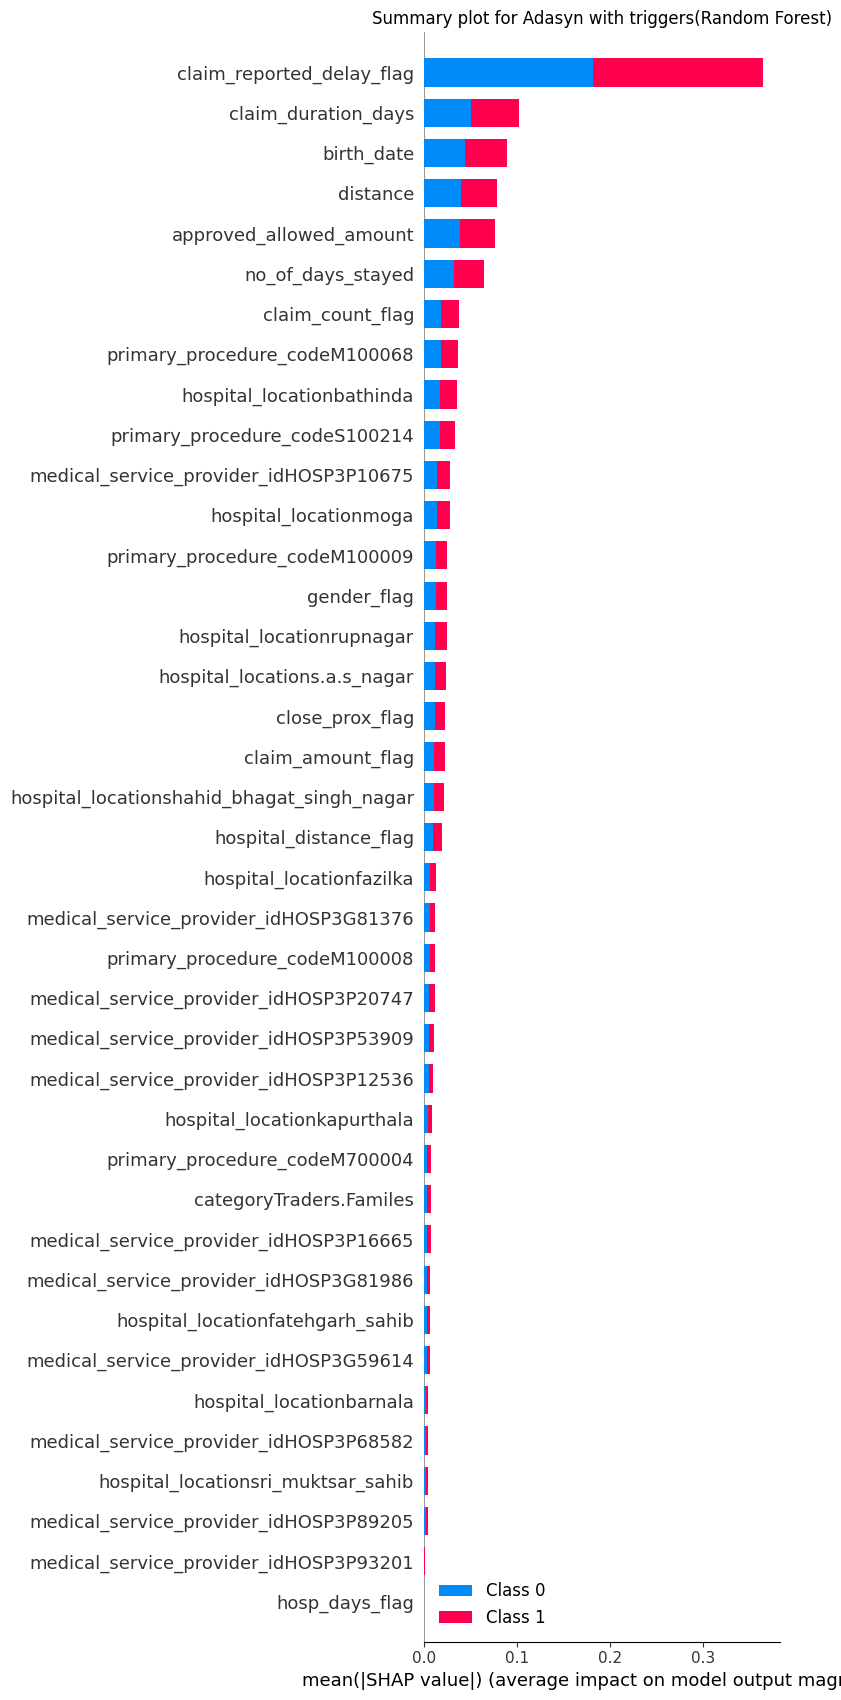

In [39]:
plt.title("Summary plot for Adasyn with triggers(Random Forest)")
shap.summary_plot(shap_value_rf, instance, feature_names=X_test.columns ,max_display=39)

Text(0.5, 1.0, 'Interaction Plot for Claim Reported Delay Flag(Random Forest)')

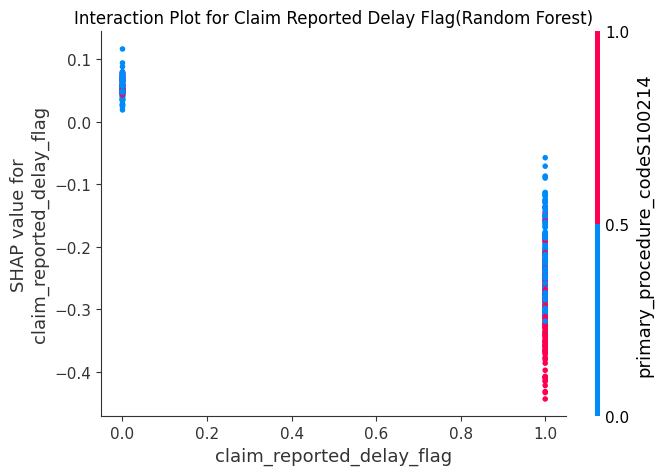

In [40]:
shap.dependence_plot('claim_reported_delay_flag', shap_value_rf[0], instance,show= False)
plt.title("Interaction Plot for Claim Reported Delay Flag(Random Forest)")

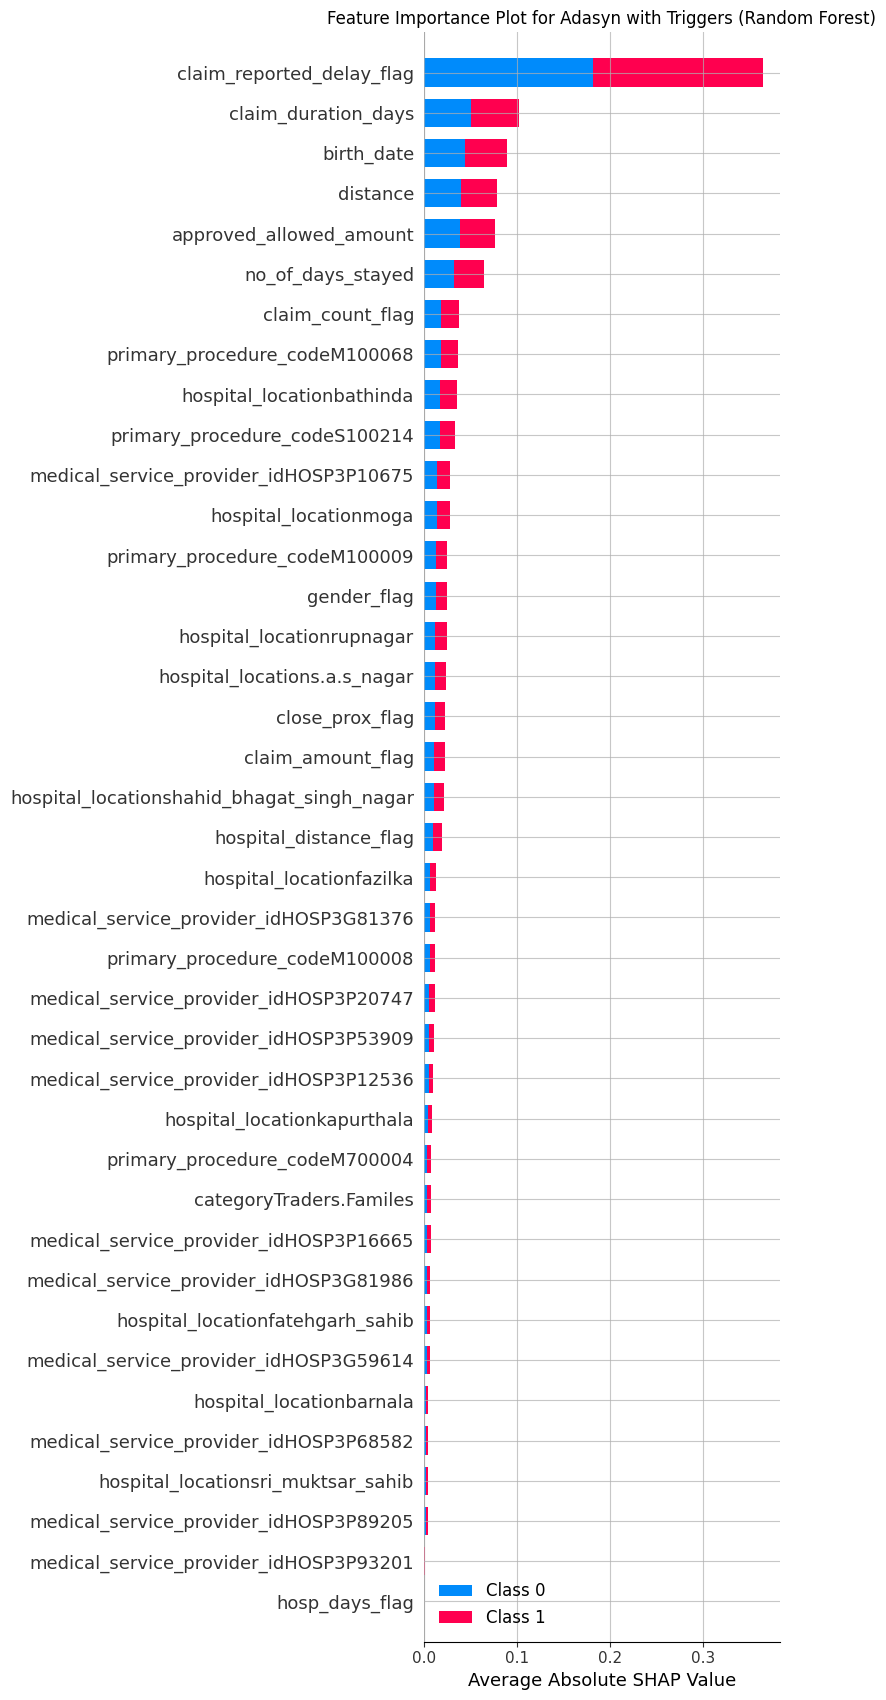

In [41]:
plt.figure(figsize=(10, 10))
plt.grid(True, axis='x', linestyle='-', alpha=0.7)
plt.grid(True, axis='y', linestyle='-', alpha=0.7)
# Plot feature importance
plt.title("Feature Importance Plot for Adasyn with Triggers (Random Forest)")
shap.summary_plot(shap_value_rf, instance,show=False,max_display=39)
plt.xlabel('Average Absolute SHAP Value')
plt.show()